In [1]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

In [3]:
# Load the dataset
df = pd.read_csv("../data/Analisis_sentimen_timnas_sepakbola_indonesia_di_era_STY.csv")

# Display the first few rows of the dataset
df.head()

,komentar,label
0,<username> Simulasi indonesia kembali dijajah ...,negatif
1,<username> <username> <username> keturunan lai...,negatif
2,<username> <username> uda botak keturunan penj...,negatif
3,"<username> <username> <username> Belum tentu, ...",negatif
4,<username> <username> <username> Lu nya aja yg...,negatif


In [4]:
# Extract the 'komentar' column as a list
X = df['komentar'].to_list()

# Extract the 'label' column as a list
y = df['label'].to_list()

In [5]:
# Preprocess Data
# Encode labels to integers
le = LabelEncoder()
encoded_y = le.fit_transform(y)

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, encoded_y, test_size=0.2, random_state=42
)

In [6]:
# Load Pre-trained Model and load pre-trained tokenizer
model_name = "indobenchmark/indobert-base-p1"  # Hugging Face model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Tokenize the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="tf")

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
# Train the Model
history = model.fit(
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    train_labels,
    validation_data=(
        {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
        test_labels
    ),
    epochs=3,
    batch_size=8
)

In [38]:
# Evaluate the Model
loss, accuracy = model.evaluate(
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
    test_labels
)
print(f"Test Accuracy: {accuracy:.4f}")

3/3 [==============================] - 3s 127ms/step - loss: 0.5359 - accuracy: 0.8000
Test Accuracy: 0.8000


In [39]:
# Make Predictions
test_predictions = model.predict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]})
predicted_labels = np.argmax(test_predictions.logits, axis=1)
decoded_predictions = le.inverse_transform(predicted_labels)

print("Predicted Sentiments:", decoded_predictions)

3/3 [==============================] - 4s 120ms/step
Predicted Sentiments: ['positif' 'positif' 'negatif' 'negatif' 'negatif' 'negatif' 'positif'
 'negatif' 'positif' 'negatif' 'negatif' 'negatif' 'negatif' 'negatif'
 'negatif' 'negatif' 'positif' 'positif' 'positif' 'positif' 'negatif'
 'negatif' 'positif' 'positif' 'negatif' 'positif' 'positif' 'positif'
 'positif' 'positif' 'positif' 'positif' 'positif' 'negatif' 'negatif'
 'negatif' 'negatif' 'positif' 'negatif' 'negatif' 'positif' 'negatif'
 'negatif' 'negatif' 'negatif' 'positif' 'negatif' 'positif' 'negatif'
 'negatif' 'positif' 'positif' 'negatif' 'negatif' 'positif' 'negatif'
 'positif' 'positif' 'negatif' 'positif' 'negatif' 'positif' 'positif'
 'positif' 'negatif' 'negatif' 'positif' 'positif' 'positif' 'negatif'
 'positif' 'positif' 'positif' 'negatif' 'positif' 'positif' 'positif'
 'positif' 'positif' 'negatif']


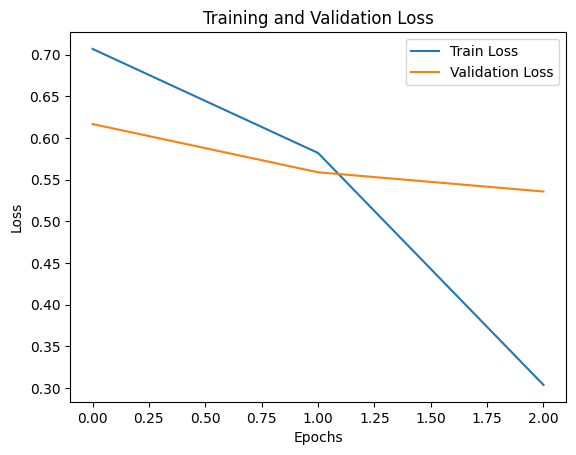

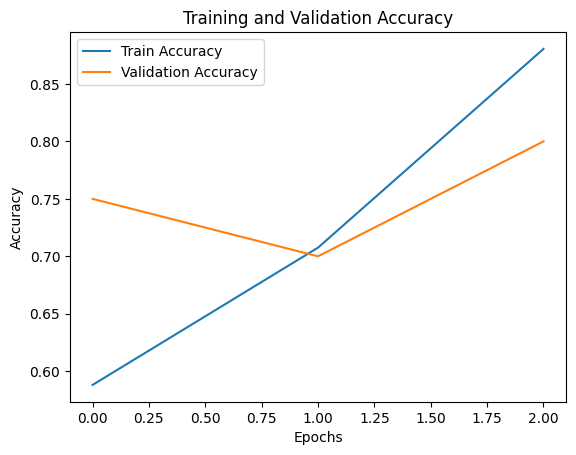

In [42]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [52]:
# 1. Save as .h5
model.save_weights("sentimen analysis/model.h5")

# 2. Save as .keras
model.save("sentimen analysis/model.keras")

# 3. Save as SavedModel
model.save("sentimen analysis/saved_model")

# 4. Save model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'sentimen analysis/tfjs_model')

# 5. Save as .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('sentimen analysis/model.tflite', 'wb') as f:
    f.write(tflite_model)